In [1]:
%config InlineBackend.figure_formats = ['svg']
import geopandas as gpd
from math import sqrt
from lxml import etree
from shapely.geometry import box
from shapely.affinity import scale, translate
from shapely.geometry.polygon import LinearRing, Polygon
from svg.path import parse_path, Line
import matplotlib.pyplot as plt

In [2]:
root = etree.parse('miller_223.svg').getroot()
paths = root.findall('.//{http://www.w3.org/2000/svg}path')
rects = root.findall('.//{http://www.w3.org/2000/svg}rect')

In [4]:
boundary_points = []
raw_boundary_points = []
for part in parse_path(paths[1].attrib['d']):
    if isinstance(part, Line):
        raw_boundary_points.append((part.start.real, part.start.imag))
        
raw_transform = paths[1].attrib['transform'].replace('matrix(', '').replace(')', '')
transform = [float(m) for m in raw_transform.split()]
a = transform[0]
b = transform[1]
c = transform[2]
d = transform[3]
e = transform[4]
f = transform[5]
for raw_x, raw_y in raw_boundary_points:
    x = a * raw_x + c * raw_y + e
    y = b * raw_x + d * raw_y + f
    boundary_points.append((x, y))

x_offset = min(x for x, _ in boundary_points)
y_offset = min(y for _, y in boundary_points)
unscaled_outer_boundary = Polygon(boundary_points)

In [5]:
guards = []
for rect in rects:
    x_hi = float(rect.attrib['x'])
    y_low = float(rect.attrib['y'])
    width = float(rect.attrib['width'])
    height = float(rect.attrib['height'])
    x_low = x_hi + width
    y_hi = y_low + height
    transform = rect.attrib['transform']
    if transform.startswith('matrix'):
        raw_transform = transform.replace('matrix(', '').replace(')', '')
        transform = [int(m) for m in raw_transform.split(',')]
        a = transform[0]
        b = transform[1]
        c = transform[2]
        d = transform[3]
        e = transform[4]
        f = transform[5]
        new_x_low = a * x_low + c * y_low + e
        new_y_low = b * x_low + d * y_low + f
        new_x_hi = a * x_hi + c * y_hi + e
        new_y_hi = b * x_hi + d * y_hi + f
        outer_rect = box(new_x_low, new_y_low, new_x_hi, new_y_hi)
    elif transform.startswith('scale'):
        raw_transform = transform.replace('scale(', '').replace(')', '')
        x_scale, y_scale = [float(s) for s in raw_transform.split(',')]
        new_x_low = x_scale * x_low
        new_x_hi = x_scale * x_hi
        new_y_low = y_scale * y_low
        new_y_hi = y_scale * y_hi
        outer_rect = box(new_x_low, new_y_low, new_x_hi, new_y_hi)
    else:
        outer_rect = (x_low, y_low, x_hi, y_hi)
    guards.append(outer_rect)

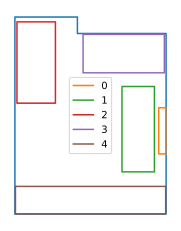

In [6]:
fig, ax = plt.subplots()
ax.plot(*unscaled_outer_boundary.exterior.coords.xy)
for idx, guard in enumerate(guards):
    ax.plot(*guard.exterior.coords.xy, label=str(idx))
ax.legend()
ax.axis('off')
ax.set_aspect('equal')

In [7]:
names = ['room', 'heater', 'desks', 'bed1', 'bed2', 'dressers']
types = ['room', *(['obstacle'] * 5)]
geometries = [unscaled_outer_boundary, *guards]
gpd.GeoDataFrame({'name': names, 'type': types, 'geometry': geometries}).to_file('miller_223.geojson', driver='GeoJSON')

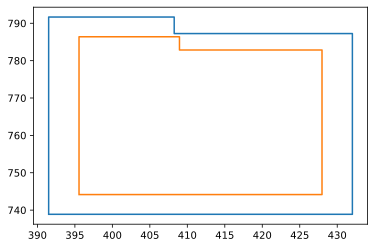

In [8]:
plt.plot(*unscaled_outer_boundary.exterior.coords.xy)
plt.plot(*scale(unscaled_outer_boundary, 0.8, 0.8).exterior.coords.xy)